# Pre-matched data with auxiliary data

In [1]:
import modelskill as ms
import numpy as np
import pandas as pd
import mikeio

In [2]:
fn = "../data/SW/eur_matched.dfs0"
mikeio.read(fn)

<mikeio.Dataset>
dims: (time:67)
time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00 (67 records)
geometry: GeometryUndefined()
items:
  0:  Hm0, model <Significant wave height> (meter)
  1:  Hm0, obs <Significant wave height> (meter)
  2:  Wind speed <Wind speed> (meter per sec)
  3:  Wind Direction <Wind Direction> (degree)

The function `from_matched()` takes a dataframe, a dfs0 or a
mikeio.Dataset of already matched data and returns a Comparer object.

In [3]:
cmp = ms.from_matched(fn, obs_item=1, mod_items=0, aux_items=[2,3])
cmp.aux_names

['Wind speed', 'Wind Direction']

In [4]:
# NOTE: we rename data_vars to avoid spaces in names
cmp = cmp.rename({"Wind speed": "wind_speed", "Wind Direction": "wind_dir"})

In [5]:
cmp.aux_names

['wind_speed', 'wind_dir']

In [6]:
cmp

<Comparer>
Quantity: Significant wave height [m]
Observation: Hm0, obs, n_points=67
Model(s):
0: Hm0, model
 Auxiliary: wind_speed
 Auxiliary: wind_dir

In [7]:
cmp.skill()

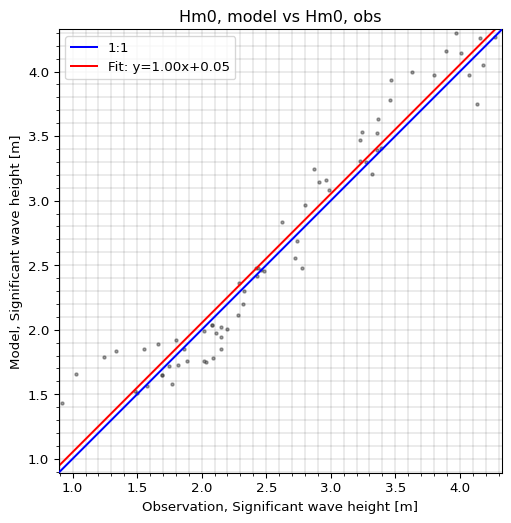

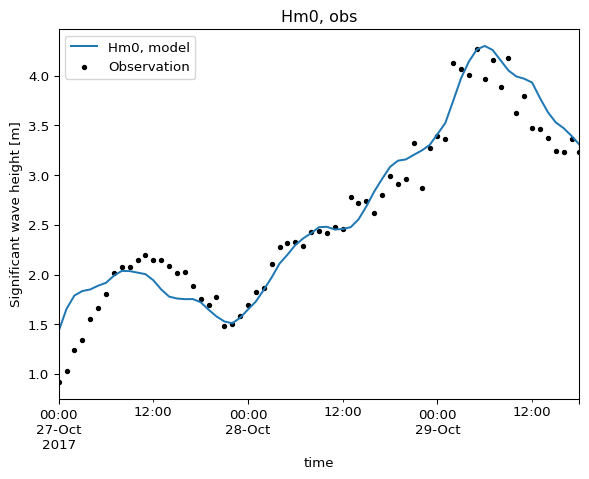

In [8]:
cmp.plot.scatter(quantiles=0, figsize=(6,6));
cmp.plot.timeseries();

## Filter

Filter on auxiliary data using `query()` or `where()`. Below, we
consider only wave data when the wind speed is above 15 m/s.

In [9]:
cmp.query("wind_speed > 15.0")

<Comparer>
Quantity: Significant wave height [m]
Observation: Hm0, obs, n_points=19
Model(s):
0: Hm0, model
 Auxiliary: wind_speed
 Auxiliary: wind_dir

In [10]:
cmp2 = cmp.where(cmp.data.wind_speed>15.0)
cmp2

<Comparer>
Quantity: Significant wave height [m]
Observation: Hm0, obs, n_points=19
Model(s):
0: Hm0, model
 Auxiliary: wind_speed
 Auxiliary: wind_dir

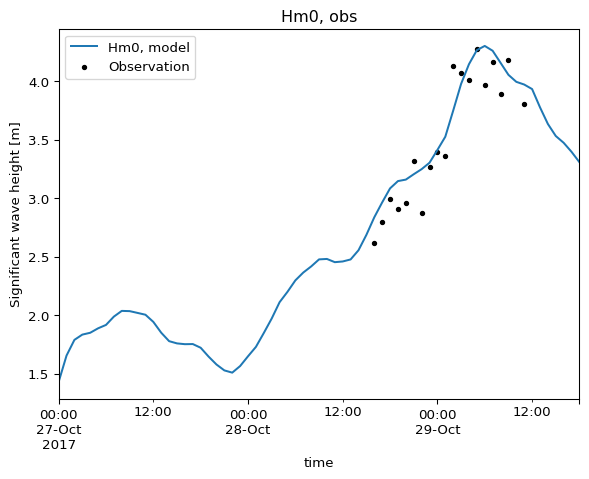

In [11]:
# notice that the model data is kept, but the observations are filtered
cmp2.plot.timeseries();

More auxiliary data can be added, e.g. as derived data from the original
data.

In [12]:
cmp.data["residual"] = cmp.data["Hm0, model"] - cmp.data["Observation"]

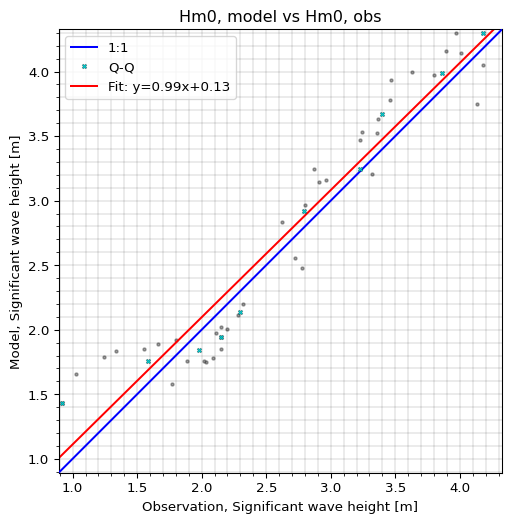

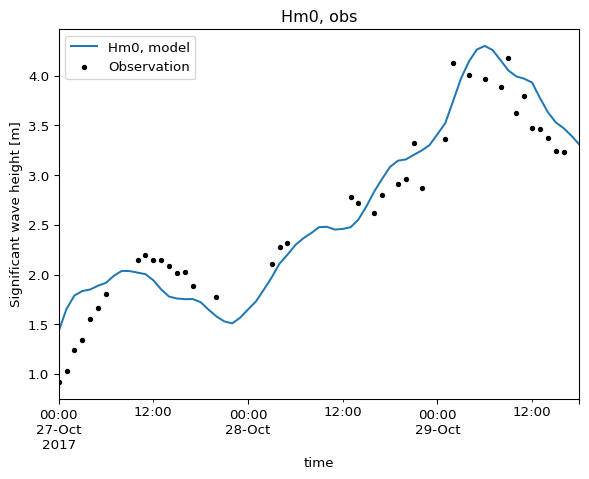

In [13]:
large_residuals = np.abs(cmp.data.residual)>0.1
cmp3 = cmp.where(large_residuals)
cmp3.plot.scatter(figsize=(6,6));
cmp3.plot.timeseries();

In [14]:
cmp3.data.data_vars

Data variables:
    Observation  (time) float64 320B 0.92 1.03 1.24 1.34 ... 3.46 3.37 3.24 3.23
    Hm0, model   (time) float64 320B 1.43 1.655 1.789 ... 3.634 3.531 3.473
    wind_speed   (time) float64 320B 9.754 11.06 11.42 10.93 ... 13.3 13.3 13.54
    wind_dir     (time) float64 320B 327.4 331.5 333.3 ... 343.0 340.8 343.6
    residual     (time) float64 320B 0.5101 0.6253 0.5495 ... 0.2907 0.2427

In [15]:
cmp3.data.Observation.values

array([0.92000002, 1.02999997, 1.24000001, 1.34000003, 1.54999995,
       1.65999997, 1.79999995, 2.1500001 , 2.20000005, 2.1500001 ,
       2.1500001 , 2.08999991, 2.01999998, 2.02999997, 1.88999999,
       1.76999998, 2.1099999 , 2.27999997, 2.31999993, 2.77999997,
       2.72000003, 2.61999989, 2.79999995, 2.91000009, 2.96000004,
       3.31999993, 2.86999989, 3.3599999 , 4.13000011, 4.01000023,
       3.97000003, 3.8900001 , 4.17999983, 3.63000011, 3.79999995,
       3.47000003, 3.46000004, 3.36999989, 3.24000001, 3.23000002])

## Aggregate

Let’s split the data based on wind direction sector and aggregate the
skill calculation of the significant wave height predition for each
sector.

*Note: in this short example wind direction is between 274 and 353
degrees*

In [16]:
df = cmp.data.wind_dir.to_dataframe()
windsectors = pd.cut(df.wind_dir,
                                [255, 285, 315, 345, 360],
                                labels=["W", "WNW", "NNW", "N"])
cmp.data["windsector"] = windsectors.astype(str)

In [17]:
cmp.skill(by="windsector")

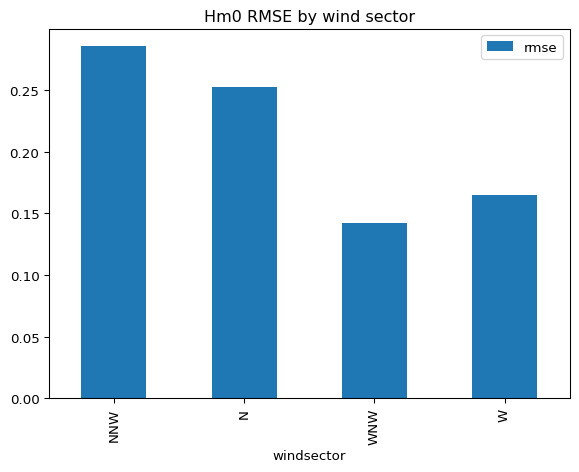

In [18]:
cmp.skill(by="windsector").rmse.plot.bar(title="Hm0 RMSE by wind sector");

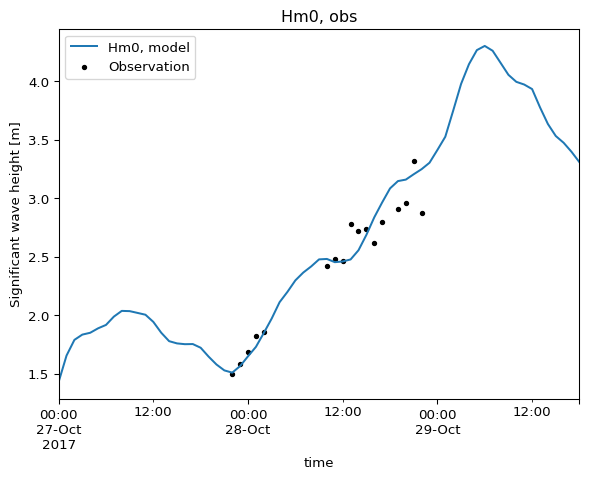

In [19]:
cmp.where(cmp.data.windsector=="W").plot.timeseries();